In [1]:
%run 'statefarm-util.ipynb'

Using Theano backend.


Found 19390 images belonging to 10 classes.
Found 3034 images belonging to 10 classes.
v5
running statefarm-predict as main. doing nothing
done


In [2]:
%run 'googlenet.ipynb'

defined googlenet


In [3]:
import h5py


class NoneClassifier(GoogleNetClassifier):
    
    def __init__(self):
        #GoogleNetClassifier.__init__(self)
        self.inception_4a_output=None
        self.inception_4d_output=None
        self.inception_5b_output=None   
    def branchOfAuxClassifer1(self, inception_4a_output):
        self.inception_4a_output = inception_4a_output

    def branchOfAuxClassifer2(self, inception_4d_output):
        self.inception_4d_output=inception_4d_output

    def mainClassfier(self, inception_5b_output):
        self.inception_5b_output = inception_5b_output
    
    def get_output(self):
        #print type(self.inception_4a_output)
        return [self.inception_4a_output,   self.inception_4d_output,  self.inception_5b_output]
    

                                                                                      




In [4]:
#googlenet expects the image format : float32, BatchxBGRxWxH (and not RGB) for example (1L, 3L, 224L, 224L)
#WxH=224x224, where values are G-= 116.779 R-= 123.68  B-= 103.939
googlenet_img_width=224
googlenet_img_height=224



import keras.preprocessing.image
from scipy.misc import imread, imresize

def load_img2(path, grayscale=False, target_size=None):
    #print 'load_img2'
   
    img = imresize(imread(path, mode='RGB'), target_size).astype(np.float32)
    return img
    
keras.preprocessing.image.load_img = load_img2

class GoogleNetImageDataGenerator(ImageDataGenerator):
    '''overrides the BGR RGB'''
    def standardize(self, x):
       
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_index = self.channel_index - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_index, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_index, keepdims=True) + 1e-7)
       
        #012 still RGB
        x[0,:,:] -= 123.68 # R
        x[1,:,:] -= 116.779 #G
        x[2,:,:] -= 103.939 #B
        #RGB to BGR
        x= x[::-1,:,:]
        #print 'standarize' , str(x.shape)  ,x.dtype
        
        if self.featurewise_center:
            x -= self.mean
        if self.featurewise_std_normalization:
            x /= (self.std + 1e-7)

        if self.zca_whitening:
            flatx = np.reshape(x, (x.size))
            whitex = np.dot(flatx, self.principal_components)
            x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))
        #channel RGB to BGR
        
        
            
        return x

googlenet_train_datagen = GoogleNetImageDataGenerator(  #transformations inside the class
        #rescale= none
        #shear_range=0.2,
        #zoom_range=0.4, #0.2
        #horizontal_flip=False 
)
#create_googlenet_mean_image()
#googlenet_train_datagen.mean = np.load('googlenet_mean_image.npy')
#print     googlenet_train_datagen.mean.shape
    
batch_size=1
num_of_batches=1

googlenet_train_generator = googlenet_train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(googlenet_img_width, googlenet_img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)

    
#this is the augmentation configuration we will use for testing: only rescaling + mean and std of training
googlenet_test_datagen = googlenet_train_datagen
googlenet_test_generator = googlenet_test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(googlenet_img_width, googlenet_img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)









Found 19390 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [5]:
#USE TO CHECK RQUALITY THAT ALL
def check_equality():
    print PATH_TO_IMGS+'cat'
    googlenet_cat_generator = googlenet_train_datagen.flow_from_directory(
            PATH_TO_IMGS+'cat',
            target_size=(googlenet_img_width, googlenet_img_height),
            batch_size=1,
            class_mode=None,
            shuffle=False) 

    model = create_googlenet(GoogleNetClassifier(), weights=None)
    load_partial_googlenet_model_weights(model,'googlenet_weights.h5')
    print('Model loaded.')
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')

    print 'googlenet transform'
    bottleneck_features_train= None
    #out is a list, as the number of the classifiers
    #out[2] is of size(#batch, 1000L)
    #so we need to iterate over out[2] and these are the results  out[2][0], out[2][1]...
    bottleneck_features_train = model.predict(googlenet_load_transform('cat.jpg'))
    print type(bottleneck_features_train)
    print 'bottleneck_features_train[0].shape',bottleneck_features_train[0].shape
    probs= bottleneck_features_train[2][0]   
    googlenet_print_matches(probs)

    print '\n my transform:"'
    bottleneck_features_train= None            
    bottleneck_features_train = model.predict_generator(googlenet_cat_generator, 2)
    print 'lenth of bottleneck' , len(bottleneck_features_train)
    best_out = bottleneck_features_train[2]
    for i in range(best_out.shape[0]): #as the batch size
        probs=best_out[i]  #the first two auxilary classifer and the 3d , best one
        print('\n')
        googlenet_print_matches(probs)

    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    print('done')

    print 'predicted'
    #285:Egyptian cat prob: 0.24039915204
    
#check_equality()



In [6]:

import random

def folder_to_label(folder):
    '''from c5 to [0,0,0,0,1,0,0,0,0,0]'''
    label = np.zeros((1,10),dtype=np.int)
    label[0][int(folder[1:])]=1
    return [label]

            
                                
def generate_data_and_label(root_path,load_transform_method,
                            transform_folder_to_label=folder_to_label,
                            file_name_transform=lambda fullname: os.path.split(fullname)[1],
                            batch_size=32,shuffle=True,
                            verbose=False  ):
    '''
    load_transform_method - mandatory- to load img and transform it (mean/channel-swap etc), or load numpy-array
    transform_folder_to_label - by default: get the middle folder (root/middle/file.jpg) like 'c9' return label, like 9
    file_name_transform - by default: from full path to file name.
                         Set to None, if you want the generator to not yield it back at all. len(result)=2   '''
    files_with_labels = [] #list of tuples
    for upper_dir in os.listdir(root_path) :
        filename_list = os.listdir(root_path +'/'+ upper_dir)
        for filename in filename_list:
            files_with_labels.append( (root_path +'/'+ upper_dir+'/'+filename, upper_dir))
    if batch_size>len(files_with_labels):
        print 'ValueError'
        raise ValueError('batch_size {} smaller than number of files {}'.format(batch_size,len(files_with_labels)))
    print 'generate_data_and_label total files=',len(files_with_labels)
    if shuffle:
        random.shuffle(files_with_labels)
    index=0
    iteration_count=0
    while 1:  #infinitiy
        if verbose and iteration_count%100==1:
            print ('iteration_count=',iteration_count)
        batch = files_with_labels[index:index+batch_size]
        missing_few = batch_size - len(batch)
        if missing_few>0:
            batch.extend(files_with_labels[0:missing_few])
            index=missing_few
        else:
            index= index+batch_size
        if verbose: print 'batch:',batch
        
        loaded_batch = np.concatenate([load_transform_method(t[0]) for t in batch])
        if verbose: print 'loaded_batch.shape',loaded_batch.shape
        
        #loaded_labels= np.concatenate([transform_folder_to_label(t[1]) for t in batch])
        #if verbose: print 'loaded_labels shape:',loaded_labels.shape,'content:',loaded_labels
        
        # IF OUTPUT LIST > 1
        #  transform_folder_to_label can return a list of elements with different shapes(1,4)   (1,20)  (1,30)
        labels_spread= [transform_folder_to_label(t[1]) for t in batch]
        # batch each of the resulting lists by itself:  1st of batch (1,4) (1,20)  (1,30)
        #                                               2nd of batch (1,4) (1,20)  (1,30)
        output_list_size= len(labels_spread[0])
        tuple_of_lists = zip(*labels_spread)  # (list of many (1,4), list of (1,20)
        loaded_labels=[np.concatenate(one_list) for one_list in tuple_of_lists]
        if verbose: 
            print 'loaded_labels list of size ' ,len(loaded_labels),'shape of 1st',loaded_labels[0].shape
        
        if file_name_transform==None:
            yield (loaded_batch, loaded_labels)
        else:
            yield (loaded_batch, loaded_labels,[ file_name_transform(t[0]) for t in batch])


def usage():
    print folder_to_label('c1').shape
    batch_generator= generate_data_and_label(PATH_TO_IMGS+'validation',
                                       googlenet_load_transform,
                                       batch_size=3,shuffle=False,verbose=True)         
    data_batch,label_batch,file_names = next(batch_generator)
    print data_batch.shape
    print label_batch
    print file_names
    data_batch,label_batch,_ = next(batch_generator)
     
    binary_np_generator=generate_data_and_label(PATH_TO_IMGS+'googlenet/train/out_1' ,
                                       load_transform_method= lambda filename: np.load(open(filename,"rb")),
                                       file_name_transform=None,batch_size=2,shuffle=True,verbose=True) 
    binary_batch,label_batch = next(binary_np_generator)
#usage()   

In [7]:

def build_folder_structure(root):
    '''  root/out_1/c0
         root/out_1/c1
            ...etc...
         root/out_2/c0
         ...
    '''
    for classifer in range(0,3):
        classifer_folder= root +"/out_"+str(classifer)
        for i in range(0,10):
            label_folder = classifer_folder+'/c'+str(i)
            if not os.path.exists(label_folder):
                os.makedirs(label_folder)


build_folder_structure ( PATH_TO_IMGS+'googlenet/train')
build_folder_structure ( PATH_TO_IMGS+'googlenet/validation')

In [8]:


model=None

from_train_generator= generate_data_and_label(PATH_TO_IMGS+'train',
                                       googlenet_load_transform,
                                       folder_to_label, #c3-> numpy containing 3
                                       batch_size=1,shuffle=False,verbose=False)    
from_validation_generator= generate_data_and_label(PATH_TO_IMGS+'validation',
                                       googlenet_load_transform,
                                       folder_to_label,
                                       batch_size=1,shuffle=False,verbose=False) 


def predict_outputs(model,batch_generator,out_root_folder,size_to_predict):
    for counter in range(size_to_predict):
        data_batch,label_batch,file_name = next(batch_generator)   # assumption batch_size=1 exactly!!!
        #PREDICT
        input_for_classifiers = model.predict(data_batch)
        #input_for_classifiers is now a list of 3 classifiers, 2 auxs and the final one
        
        for i,input_i in enumerate(input_for_classifiers):
            folder = out_root_folder + '/out_'+str(i) +'/c'+ str(label_batch[0]) +'/'
            np.save(open(folder+'out_{}.npy'.format(file_name[0]), 'wb'), input_i)
            if counter==0:
                print 'output for classifier',i , input_i.shape
            
def usage():
    #start model and generator
    no_head_model = create_googlenet(NoneClassifier(), weights=None)
    load_partial_googlenet_model_weights(no_head_model,'googlenet_weights.h5')
    print('Model loaded: no_head_model')
    no_head_model.compile(optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy')

    
    
    %time predict_outputs(no_head_model, from_train_generator,     PATH_TO_IMGS+'googlenet/train'     ,19390)  #19390
    %time predict_outputs(no_head_model, from_validation_generator,PATH_TO_IMGS+'googlenet/validation',3034)  #3034
    
    
#usage()




In [9]:


def usage():
    model=None
    
    #create and compile a no-head model
    print ('no_head_model')
    no_head_model = create_googlenet(NoneClassifier(), weights=None)
    load_partial_googlenet_model_weights(no_head_model,'googlenet_weights.h5')
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    no_head_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    
    #now head model
    inception_5b_output = Input(shape=(1024,7,7))
    pool5_7x7_s1 = AveragePooling2D(pool_size=(7,7),strides=(1,1),name='pool5/7x7_s2')(inception_5b_output)
    loss3_flat = Flatten()(pool5_7x7_s1)
    pool5_drop_7x7_s1 = Dropout(0.4)(loss3_flat)
    loss3_classifier = Dense(1000,name='loss3/classifier',W_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
    loss3_classifier_act = Activation('softmax',name='prob')(loss3_classifier)
    head_model =  m= Model(input=inception_5b_output,output=loss3_classifier_act)
    
    print ('\n\nloading head_model')
    load_partial_googlenet_model_weights(head_model,'googlenet_weights.h5')
    head_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    
    def predict_from_mem():
        print ('\n\npredict_from_mem')
        data, label, files = next(from_train_generator)
        print data.shape, label.shape, label, files
        no_head_outputs = no_head_model.predict(data)
        print 'no_head_outputs[2].shape', no_head_outputs[2].shape
        head_output   = head_model.predict( no_head_outputs[2])
        googlenet_print_matches(head_output[0]) #looks good >0.5 of seatbelt
        
       
        file_name= 'predict_from_mem.npy'
        saved = no_head_outputs[2]
        np.save(open(file_name, 'wb'), saved)  #note b is needed in windows as text-file on windows are altered by python
        loaded = np.load(open(file_name,'rb'))
        # saved should be ==loaded
        head_output   = head_model.predict( loaded)
        googlenet_print_matches(head_output[0]) #looks good >0.5 of seatbelt
    
    def predict_from_file():
        print ('\n\npredict_from_file')
        from_googlenet_generator= generate_data_and_label(PATH_TO_IMGS+'googlenet/train/out_2' ,
                                  load_transform_method= lambda filename: np.load(open(filename,"rb")),
                                  batch_size=1,shuffle=True,verbose=False) 
        data, label ,files= next(from_googlenet_generator)
        print data.shape, label.shape, label,files
        no_head_outputs = data
        output = head_model.predict(no_head_outputs)
        googlenet_print_matches(output[0])
    predict_from_mem()
    predict_from_file()
    

#usage()



In [10]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential

   

def branchOfAuxClassifer0(includeInput=None): 
    if (includeInput):
        inception_4a_output=includeInput
    else:
        inception_4a_output= Input(shape=(512, 14, 14))
    loss1_ave_pool = AveragePooling2D(pool_size=(5,5),strides=(3,3),name='loss1/ave_pool')(inception_4a_output)
    loss1_conv = Convolution2D(128,1,1,border_mode='same',activation='relu',name='loss1/conv',W_regularizer=l2(0.0002))(loss1_ave_pool)
    loss1_flat = Flatten()(loss1_conv)
    loss1_fc = Dense(1024,activation='relu',name='loss1/fc',W_regularizer=l2(0.0002))(loss1_flat)
    loss1_drop_fc = Dropout(0.7)(loss1_fc)
    loss1_classifier = Dense(10,name='loss1/classifier',W_regularizer=l2(0.0002))(loss1_drop_fc)
    loss1_classifier_act = Activation('softmax',name='prob_aux0')(loss1_classifier)
    
    if includeInput:
        return loss1_classifier_act
    else:
        return Model(input=inception_4a_output, output=loss1_classifier_act)

def branchOfAuxClassifer1(includeInput=None): 
    if (includeInput):
        inception_4d_output=includeInput
    else:
        inception_4d_output  = Input(shape=(528, 14, 14))
   
    loss2_ave_pool = AveragePooling2D(pool_size=(5,5),strides=(3,3),name='loss2/ave_pool')(inception_4d_output)
    loss2_conv = Convolution2D(128,1,1,border_mode='same',activation='relu',name='loss2/conv',W_regularizer=l2(0.0002))(loss2_ave_pool)
    loss2_flat = Flatten()(loss2_conv)
    loss2_fc = Dense(1024,activation='relu',name='loss2/fc',W_regularizer=l2(0.0002))(loss2_flat)
    loss2_drop_fc = Dropout(0.7)(loss2_fc)
    loss2_classifier = Dense(10,name='loss2/classifier',W_regularizer=l2(0.0002))(loss2_drop_fc)
    loss2_classifier_act = Activation('softmax',name='prob_aux1')(loss2_classifier)   
    if includeInput:
        return loss2_classifier_act
    else:
        return Model(input=inception_4d_output, output=loss2_classifier_act)


   
def mainClassfier2(includeInput=None):  #2
    if (includeInput):
        inception_5b_output = includeInput
    else: 
        inception_5b_output = Input(shape=(1024,7,7))
    pool5_7x7_s1 = AveragePooling2D(pool_size=(7,7),strides=(1,1),name='pool5/7x7_s2')(inception_5b_output)
    loss3_flat = Flatten()(pool5_7x7_s1)
    pool5_drop_7x7_s1 = Dropout(0.4)(loss3_flat)
    loss3_classifier = Dense(10,name='loss3/classifier',W_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
    loss3_classifier_act = Activation('softmax',name='prob')(loss3_classifier)
    
    if (includeInput):
        return loss3_classifier_act
    else:
        return  Model(input=inception_5b_output,output=loss3_classifier_act)
    

model=None
head_model=None





In [11]:
def train_classifier():  #change this for out_0 and out_2
    model= branchOfAuxClassifer1()
    classifer_folder='out_1'
    model.compile(optimizer='rmsprop',  loss='categorical_crossentropy',    metrics=['accuracy'])
    print 'compiled model'
    from_train_generator= generate_data_and_label(PATH_TO_IMGS+'googlenet/train/'+classifer_folder ,
                                       load_transform_method= lambda filename: np.load(open(filename,"rb")),
                                       file_name_transform=None,batch_size=32,shuffle=True,verbose=False) 
    from_valid_generator= generate_data_and_label(PATH_TO_IMGS+'googlenet/validation/'+classifer_folder ,
                                       load_transform_method= lambda filename: np.load(open(filename,"rb")),
                                       file_name_transform=None,batch_size=32,shuffle=False,verbose=False)  
    history_list=[]    
    for i in range (0,20):
        history=model.fit_generator(from_train_generator, samples_per_epoch=10000, nb_epoch=1, verbose=1,
                            callbacks=[], validation_data=from_valid_generator, nb_val_samples=3034, class_weight=None, max_q_size=3) 
        history_list.append(history)
        saveToFiles(model,'model_chapter6_aux1_try2_'+str(i)+'epoc')
        if i>1 and i%5==0:
            graph_history(history_list)
    print 'done'
    
#train_classifier()    #now tried it without the new init which I tried before

In [12]:

def folder_to_3_labels(folder):
    '''from c5 to [0,0,0,0,1,0,0,0,0,0]'''
    label = np.zeros((1,10),dtype=np.int)
    c_num = int(folder[1:]) #'c9'
    label[0,c_num]=1
    return [label,label,label]

##folder_to_label('c4')
   
    

train_g= generate_data_and_label(PATH_TO_IMGS+'train',
                                       load_transform_method=googlenet_load_transform,
                                       transform_folder_to_label=folder_to_3_labels,
                                       file_name_transform=None,
                                       batch_size=32,shuffle=True,verbose=False)   

val_g= generate_data_and_label(PATH_TO_IMGS+'validation',
                                       load_transform_method=googlenet_load_transform,
                                       transform_folder_to_label=folder_to_3_labels,
                                       file_name_transform=None,
                                       batch_size=32,shuffle=True,verbose=False) 
print 'generators defined'
#data, label = next(train_g)
#print label
#print full_model.output_shape



generators defined


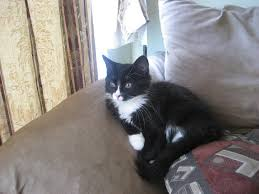

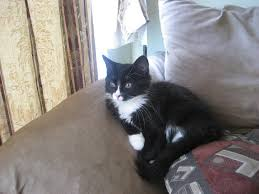

In [13]:


import keras.preprocessing.image as image
def googlenet_augment(image_name):
    def plotme():
        plt.figure()
        plt.imshow(img)
        plt.show()
    
    img = imresize(imread(image_name, mode='RGB'), (224, 224)).astype(np.float32)
   # plotme()
    img[:, :, 0] -= 123.68
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 103.939
    
   # plotme()
    img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
   # plotme()
    img = img.transpose((2, 0, 1))
    #plotme()
   
    img=image.random_zoom(img,[0.1,0.1])
    img=image.random_shear(img,0.1)
    if random.random()<0.5:
        img=image.flip_axis(img, 2) # img_col_index=2
    img =np.expand_dims(img, axis=0) 
    #plotme()
    
    return img

x= googlenet_augment('cat.jpg')
from IPython.display import Image, display

listOfImageNames = ['cat.jpg',
                    'cat.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName))




In [14]:
from keras.optimizers import SGD


def create_full_model_only_aux0(filename):
    nc=NoneClassifier()
    no_head_model = create_googlenet(nc, weights=None)
    load_partial_googlenet_model_weights(no_head_model,'googlenet_weights.h5')
    outputs = [branchOfAuxClassifer0(nc.inception_4a_output)  ]
    full_model_aux0 = Model(input=no_head_model.input, output=outputs) #maybe change this to model.outut?
    load_partial_googlenet_model_weights(full_model_aux0,filename,verbose=False)
    return full_model_aux0


def create_full_model_3_classifiers():
    model = None
    nc=NoneClassifier()
    no_head_model = create_googlenet(nc, weights=None)
    load_partial_googlenet_model_weights(no_head_model,'googlenet_weights.h5')
    no_head_model_layers= dict(zip([layer.name for layer in no_head_model.layers],no_head_model.layers))
    print 'no_head_model loaded'


    #TODO retrain model_chapter6_aux1, I just invented here something....
    head_model_h5_files = ['current/model_chapter6_aux0_25epoc.h5',
                           'current/model_chapter6_aux1_try2_11epoc.h5',
                           'current/model_chapter6_12epoc.h5'
                          ]
    classifier_func = [ branchOfAuxClassifer0, 
                        branchOfAuxClassifer1, 
                        mainClassfier2
                      ]

    no_head_connection_vars= [nc.inception_4a_output ,
                              nc.inception_4d_output,
                              nc.inception_5b_output
                             ]

    outputs=[]
    for i in range(len(head_model_h5_files)):
        output = classifier_func[i](no_head_connection_vars[i])  
        outputs.append(output)

    full_model = Model(input=no_head_model.input, output=outputs) #maybe change this to model.outut?
    print 'model defined'

    #load wieghts:  TODO: check no naming collision here, or missing name
    for i in range(len(head_model_h5_files)):
        print i, 'loading file ',head_model_h5_files[i]
        load_partial_googlenet_model_weights(full_model,head_model_h5_files[i],verbose=False)
    print 'loaded pre-trained'
    return full_model
    
 

def finetune(full_model):
    #make most layers un-trainalbe
    trainable={ 'loss1',  #loss1/classifier','loss1/conv','loss1/fc', 
                'loss2',  #loss2/classifier','loss2/conv','loss2/fc',
                'loss3',  #loss3/classifier',
                'inception_3b',
                'inception_4a' }
    for layer in full_model.layers:
        if layer.name.split("/")[0] in trainable:  
            layer.trainable = True
            print 'training layer',layer.name
        else:
           layer.trainable = False

    full_model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    print 'model compiled'
    history_list=[]    
    gennn_aug= generate_data_and_label(PATH_TO_IMGS+'train',
                                       load_transform_method=googlenet_augment,#AUGMENT
                                       transform_folder_to_label=folder_to_label,
                                       file_name_transform=None,
                                       batch_size=32,shuffle=True)
    gennn_val= generate_data_and_label(PATH_TO_IMGS+'validation',
                                       load_transform_method=googlenet_load_transform,
                                       transform_folder_to_label=folder_to_label,
                                       file_name_transform=None,
                                       batch_size=32,shuffle=True,verbose=False)  #note- NO SHUFFLE
    
    for i in range (0,50):
        history=full_model.fit_generator(gennn_aug, samples_per_epoch=5000, nb_epoch=1, verbose=1,
                            callbacks=[], validation_data=gennn_val, nb_val_samples=1000 ,class_weight=None, max_q_size=3) 
        history_list.append(history)
        saveToFiles(full_model,'model_chapter6_finetune_aux0_lr_1e4_binary'+str(i)+'epoc')
        if i>1 and i%2==0:
            graph_history(history_list)
    return history_list




In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def print_report(classes_list,all_prbs):
    #see http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
    y_true =  [int(c) for c in classes_list]
    y_pred = [np.argmax(probs) for probs in all_probs]
    print y_true
    print y_pred
    c_matrix = confusion_matrix(y_true, y_pred)
    print c_matrix
    target_names = [str(i)+' '+labelMapping['c'+str(i)] for i in range(0,10)]
    print(classification_report(y_true, y_pred, target_names=target_names))


training layer inception_3b/3x3_reduce
training layer inception_3b/5x5_reduce
training layer inception_3b/pool
training layer inception_3b/1x1
training layer inception_3b/3x3
training layer inception_3b/5x5
training layer inception_3b/pool_proj
training layer inception_3b/output
training layer inception_4a/3x3_reduce
training layer inception_4a/5x5_reduce
training layer inception_4a/pool
training layer inception_4a/1x1
training layer inception_4a/3x3
training layer inception_4a/5x5
training layer inception_4a/pool_proj
training layer inception_4a/output
training layer loss1/ave_pool
training layer loss1/conv
training layer loss1/fc
training layer loss1/classifier
model compiled
Epoch 1/1
generate_data_and_label total files= 19390
4992/5000 [============================>.] - ETA: 3s - loss: 1.1844 - acc: 0.1088 

C:\Python27\Anaconda2\1\lib\site-packages\keras\engine\training.py:1403: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


generate_data_and_label total files= 3034
5024/5000 [==============================] - 2543s - loss: 1.1829 - acc: 0.1089 - val_loss: 0.1094 - val_acc: 0.8887
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary0epoc
Epoch 1/1
5024/5000 [==============================] - 2618s - loss: 0.9538 - acc: 0.1194 - val_loss: 0.0977 - val_acc: 0.8857
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary1epoc
Epoch 1/1
5024/5000 [==============================] - 2599s - loss: 0.9477 - acc: 0.1290 - val_loss: 0.0964 - val_acc: 0.8809
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary2epoc


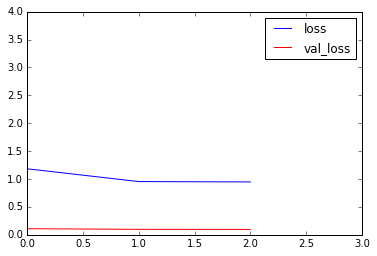

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522]
[0.888671875, 0.8857421875, 0.880859375]


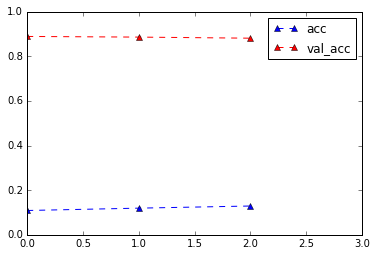

Epoch 1/1
5024/5000 [==============================] - 2577s - loss: 0.9436 - acc: 0.1419 - val_loss: 0.1107 - val_acc: 0.8828
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary3epoc
Epoch 1/1
5024/5000 [==============================] - 2666s - loss: 0.9430 - acc: 0.1547 - val_loss: 0.1009 - val_acc: 0.8779
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary4epoc


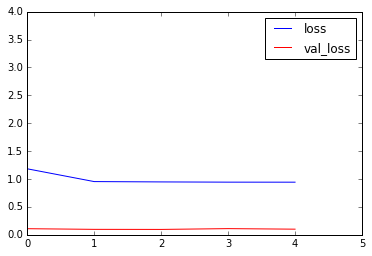

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875]


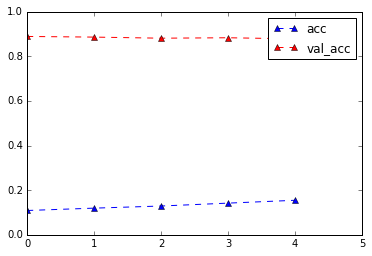

Epoch 1/1
5024/5000 [==============================] - 2286s - loss: 0.9418 - acc: 0.1572 - val_loss: 0.1047 - val_acc: 0.8740
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary5epoc
Epoch 1/1
5024/5000 [==============================] - 2291s - loss: 0.9407 - acc: 0.1545 - val_loss: 0.1024 - val_acc: 0.8916
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary6epoc


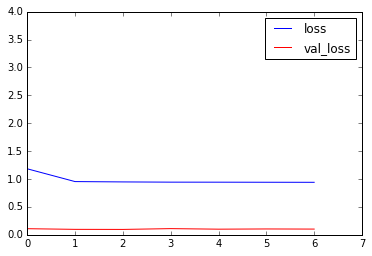

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625]


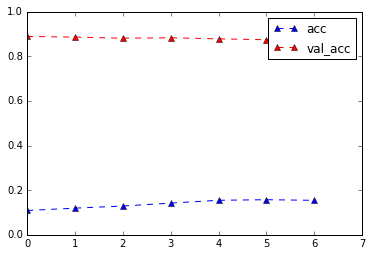

Epoch 1/1
5024/5000 [==============================] - 2291s - loss: 0.9387 - acc: 0.1771 - val_loss: 0.1001 - val_acc: 0.8691
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary7epoc
Epoch 1/1
5024/5000 [==============================] - 1748s - loss: 0.9386 - acc: 0.1768 - val_loss: 0.0992 - val_acc: 0.8740
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary8epoc


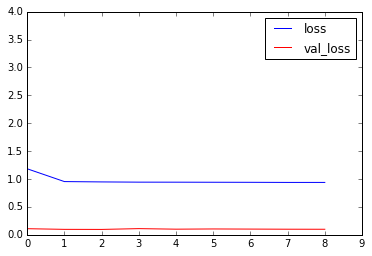

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375]


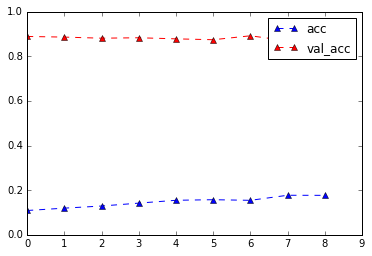

Epoch 1/1
5024/5000 [==============================] - 1733s - loss: 0.9372 - acc: 0.1863 - val_loss: 0.1022 - val_acc: 0.8857
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary9epoc
Epoch 1/1
5024/5000 [==============================] - 1733s - loss: 0.9367 - acc: 0.1734 - val_loss: 0.1051 - val_acc: 0.8643
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary10epoc


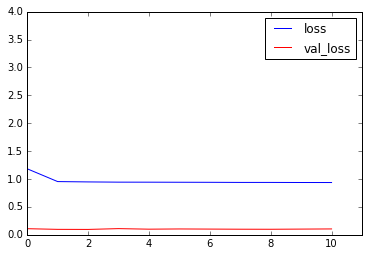

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125]


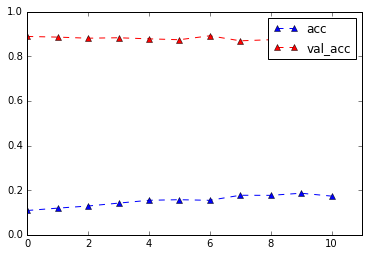

Epoch 1/1
5024/5000 [==============================] - 1863s - loss: 0.9356 - acc: 0.1871 - val_loss: 0.1011 - val_acc: 0.8740
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary11epoc
Epoch 1/1
5024/5000 [==============================] - 1912s - loss: 0.9342 - acc: 0.1835 - val_loss: 0.0982 - val_acc: 0.8916
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary12epoc


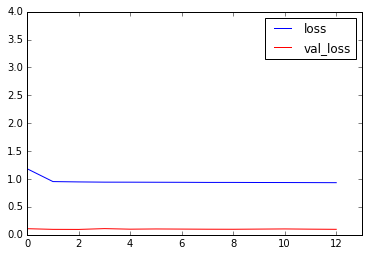

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625]


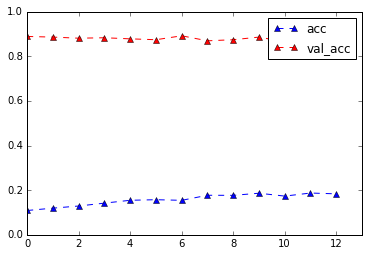

Epoch 1/1
5024/5000 [==============================] - 1898s - loss: 0.9350 - acc: 0.1847 - val_loss: 0.1044 - val_acc: 0.8604
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary13epoc
Epoch 1/1
5024/5000 [==============================] - 1873s - loss: 0.9307 - acc: 0.1921 - val_loss: 0.1124 - val_acc: 0.8652
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary14epoc


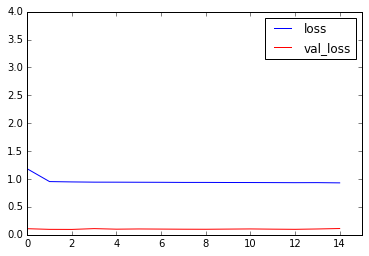

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375]


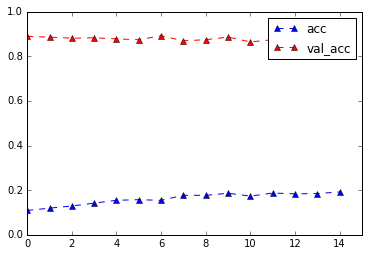

Epoch 1/1
5024/5000 [==============================] - 1832s - loss: 0.9327 - acc: 0.1859 - val_loss: 0.0877 - val_acc: 0.8936
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary15epoc
Epoch 1/1
5024/5000 [==============================] - 1746s - loss: 0.9308 - acc: 0.1911 - val_loss: 0.1036 - val_acc: 0.8584
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary16epoc


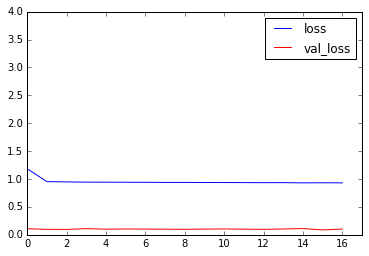

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375]


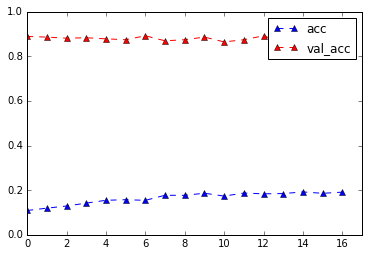

Epoch 1/1
5024/5000 [==============================] - 1739s - loss: 0.9324 - acc: 0.1813 - val_loss: 0.1068 - val_acc: 0.8740
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary17epoc
Epoch 1/1
5024/5000 [==============================] - 1746s - loss: 0.9273 - acc: 0.2006 - val_loss: 0.0934 - val_acc: 0.8877
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary18epoc


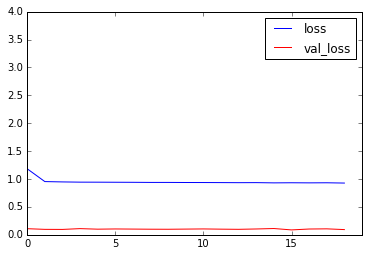

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125]


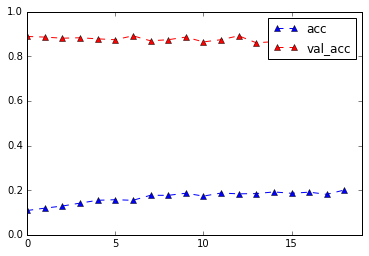

Epoch 1/1
5024/5000 [==============================] - 1742s - loss: 0.9283 - acc: 0.2100 - val_loss: 0.1013 - val_acc: 0.8574
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary19epoc
Epoch 1/1
5024/5000 [==============================] - 1746s - loss: 0.9253 - acc: 0.2172 - val_loss: 0.1089 - val_acc: 0.8691
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary20epoc


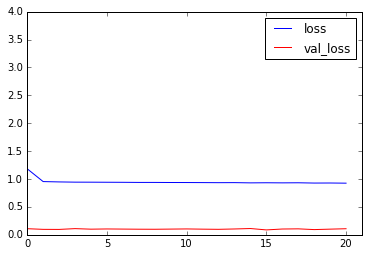

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.857421875, 0.869140625]


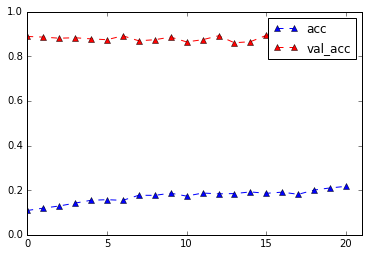

Epoch 1/1
5024/5000 [==============================] - 1740s - loss: 0.9282 - acc: 0.2076 - val_loss: 0.0985 - val_acc: 0.8818
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary21epoc
Epoch 1/1
5024/5000 [==============================] - 1747s - loss: 0.9245 - acc: 0.2223 - val_loss: 0.1037 - val_acc: 0.8496
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary22epoc


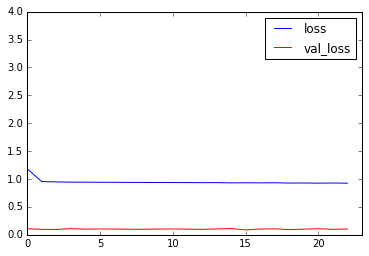

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.857421875, 0.869140625, 0.8818359375, 0.849609375]


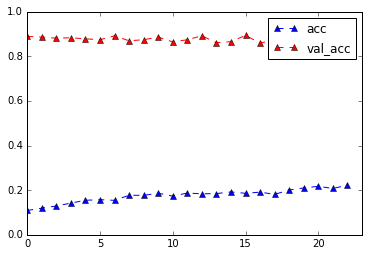

Epoch 1/1
5024/5000 [==============================] - 1745s - loss: 0.9251 - acc: 0.2205 - val_loss: 0.1078 - val_acc: 0.8701
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary23epoc
Epoch 1/1
5024/5000 [==============================] - 1746s - loss: 0.9229 - acc: 0.2369 - val_loss: 0.0960 - val_acc: 0.8740
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary24epoc


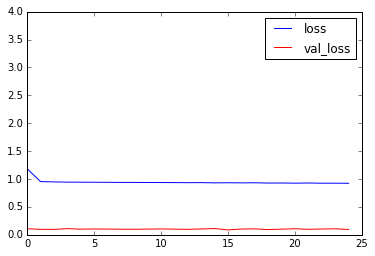

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.857421875, 0.869140625, 0.8818359375, 0.849609375, 0.8701171875, 0.8740234375]


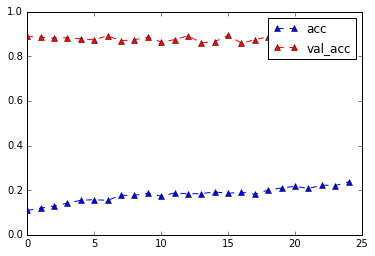

Epoch 1/1
5024/5000 [==============================] - 1746s - loss: 0.9257 - acc: 0.2158 - val_loss: 0.1000 - val_acc: 0.8594
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary25epoc
Epoch 1/1
5024/5000 [==============================] - 1750s - loss: 0.9233 - acc: 0.2283 - val_loss: 0.1065 - val_acc: 0.8750
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary26epoc


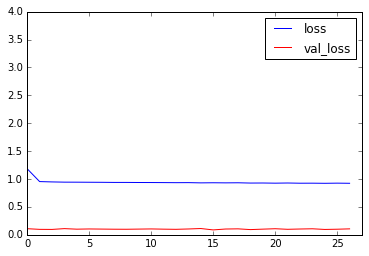

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075, 0.21576433121019109, 0.22830414012738853]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.857421875, 0.869140625, 0.8818359375, 0.849609375, 0.8701171875, 0.8740234375, 0.859375, 0.875]


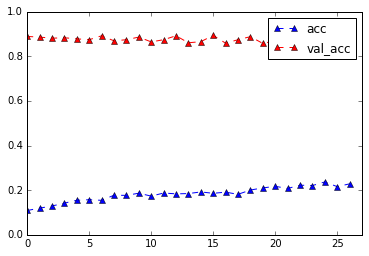

Epoch 1/1
5024/5000 [==============================] - 1747s - loss: 0.9216 - acc: 0.2371 - val_loss: 0.1008 - val_acc: 0.8604
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary27epoc
Epoch 1/1
5024/5000 [==============================] - 1746s - loss: 0.9221 - acc: 0.2299 - val_loss: 0.1045 - val_acc: 0.8574
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary28epoc


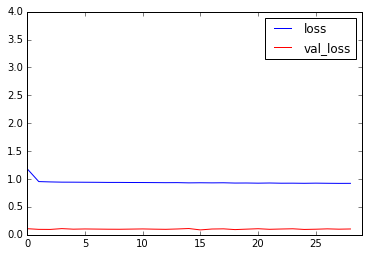

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075, 0.21576433121019109, 0.22830414012738853, 0.23706210191082802, 0.22989649681528662]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.857421875, 0.869140625, 0.8818359375, 0.849609375, 0.8701171875, 0.8740234375, 0.859375, 0.875, 0.8603515625, 0.857421875]


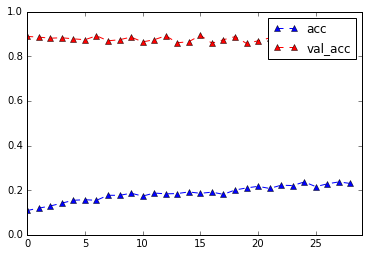

Epoch 1/1
5024/5000 [==============================] - 1743s - loss: 0.9211 - acc: 0.2207 - val_loss: 0.1010 - val_acc: 0.8770
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary29epoc
Epoch 1/1
5024/5000 [==============================] - 1739s - loss: 0.9215 - acc: 0.2319 - val_loss: 0.1018 - val_acc: 0.8555
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary30epoc


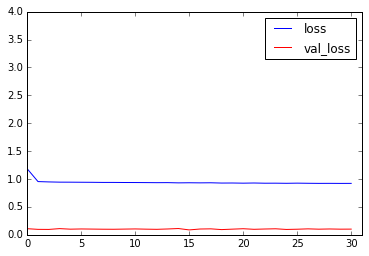

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075, 0.21576433121019109, 0.22830414012738853, 0.23706210191082802, 0.22989649681528662, 0.22074044585987262, 0.23188694267515925]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.857421875, 0.869140625, 0.8818359375, 0.849609375, 0.8701171875, 0.8740234375, 0.859375, 

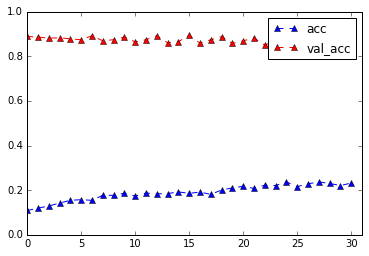

Epoch 1/1
5024/5000 [==============================] - 1761s - loss: 0.9188 - acc: 0.2514 - val_loss: 0.1027 - val_acc: 0.8574
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary31epoc
Epoch 1/1
5024/5000 [==============================] - 1843s - loss: 0.9196 - acc: 0.2458 - val_loss: 0.1005 - val_acc: 0.8721
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary32epoc


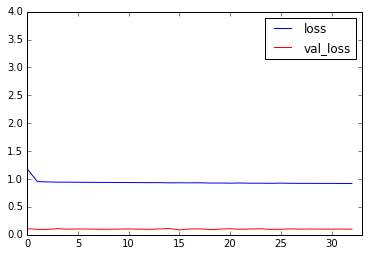

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075, 0.21576433121019109, 0.22830414012738853, 0.23706210191082802, 0.22989649681528662, 0.22074044585987262, 0.23188694267515925, 0.25139331210191085, 0.24582006369426751]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.857421875, 0.869140625, 0.8818359375, 0.8496093

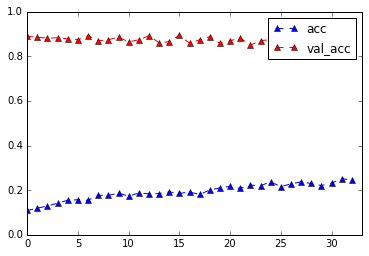

Epoch 1/1
5024/5000 [==============================] - 1815s - loss: 0.9175 - acc: 0.2442 - val_loss: 0.1056 - val_acc: 0.8486
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary33epoc
Epoch 1/1
5024/5000 [==============================] - 1788s - loss: 0.9179 - acc: 0.2540 - val_loss: 0.1031 - val_acc: 0.8623
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary34epoc


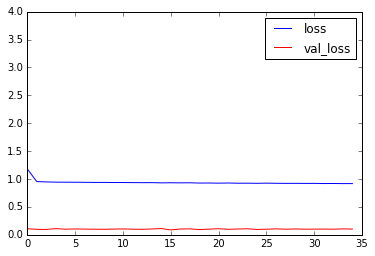

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075, 0.21576433121019109, 0.22830414012738853, 0.23706210191082802, 0.22989649681528662, 0.22074044585987262, 0.23188694267515925, 0.25139331210191085, 0.24582006369426751, 0.24422770700636942, 0.25398089171974525]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.8583984375, 0.8740234375, 0.8876953125, 0.85742

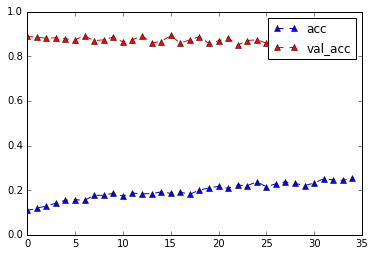

Epoch 1/1
5024/5000 [==============================] - 1841s - loss: 0.9157 - acc: 0.2621 - val_loss: 0.0990 - val_acc: 0.8721
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary35epoc
Epoch 1/1
5024/5000 [==============================] - 1856s - loss: 0.9190 - acc: 0.2524 - val_loss: 0.1015 - val_acc: 0.8467
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary36epoc


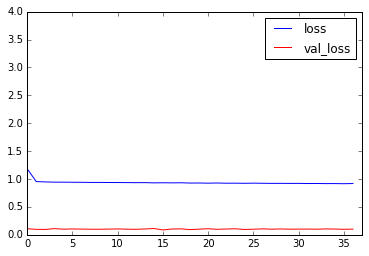

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075, 0.21576433121019109, 0.22830414012738853, 0.23706210191082802, 0.22989649681528662, 0.22074044585987262, 0.23188694267515925, 0.25139331210191085, 0.24582006369426751, 0.24422770700636942, 0.25398089171974525, 0.26214171974522293, 0.25238853503184716]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603515625, 0.865234375, 0.8935546875, 0.85839

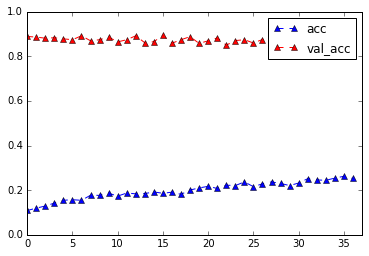

Epoch 1/1
5024/5000 [==============================] - 1861s - loss: 0.9146 - acc: 0.2580 - val_loss: 0.1136 - val_acc: 0.8564
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary37epoc
Epoch 1/1
5024/5000 [==============================] - 1881s - loss: 0.9160 - acc: 0.2524 - val_loss: 0.0952 - val_acc: 0.8740
Saved model to disk model_chapter6_finetune_aux0_lr_1e4_binary38epoc


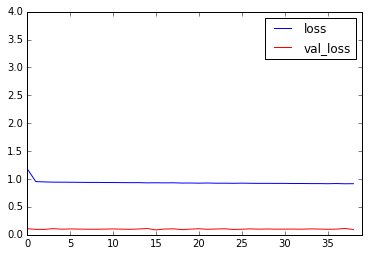

[0.10887738853503184, 0.11942675159235669, 0.12898089171974522, 0.1419187898089172, 0.15465764331210191, 0.15724522292993631, 0.15445859872611464, 0.17714968152866242, 0.17675159235668789, 0.18630573248407642, 0.17336783439490447, 0.18710191082802546, 0.18351910828025478, 0.18471337579617833, 0.192078025477707, 0.18590764331210191, 0.19108280254777071, 0.18132961783439491, 0.20063694267515925, 0.20999203821656051, 0.21715764331210191, 0.20760350318471338, 0.22233280254777071, 0.22054140127388536, 0.23686305732484075, 0.21576433121019109, 0.22830414012738853, 0.23706210191082802, 0.22989649681528662, 0.22074044585987262, 0.23188694267515925, 0.25139331210191085, 0.24582006369426751, 0.24422770700636942, 0.25398089171974525, 0.26214171974522293, 0.25238853503184716, 0.25796178343949044, 0.25238853503184716]
[0.888671875, 0.8857421875, 0.880859375, 0.8828125, 0.8779296875, 0.8740234375, 0.8916015625, 0.869140625, 0.8740234375, 0.8857421875, 0.8642578125, 0.8740234375, 0.8916015625, 0.8603

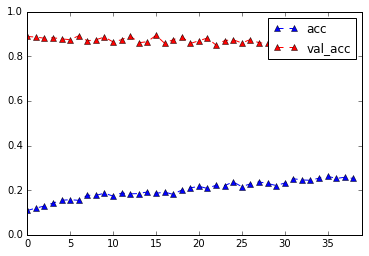

Epoch 1/1
 576/5000 [==>...........................] - ETA: 1483s - loss: 0.9128 - acc: 0.2639

KeyboardInterrupt: 

In [16]:

def predict_all_directory_googlenet(model,directory,total_files,transform_folder_to_label,file_name_transform):
    batch_size=32
    submit_generator= generate_data_and_label(directory,load_transform_method=googlenet_load_transform,
                                                        transform_folder_to_label=transform_folder_to_label,
                                                        file_name_transform=file_name_transform,
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        verbose=False)
    num_of_batchs = total_files/batch_size
    mod = total_files%batch_size
    if mod: 
        num_of_batchs+=1
        
    list_of_probs_batches=[]
    all_file_names=[]
    for batch_i in range(0,num_of_batchs):
        data_batch,_,file_names= next(submit_generator)  #batch of 32 images
        #x = np.asarray(x_list)
        curr_probs = model.predict( data_batch, batch_size)
        list_of_probs_batches.append(curr_probs)
        all_file_names.append(file_names)
        if batch_i%10==1:
            print batch_i, list_of_probs_batches[batch_i].shape
            
    all_probs =  np.concatenate(list_of_probs_batches,axis=0)
    return sum(all_file_names,[]) , all_probs


def calculate_googlenet_val_score(m,samples=3034):
    #model_name='aux0'
    #m=create_full_model_only_aux0()
    c_name_list,all_probs= predict_all_directory_googlenet(m,validation_data_dir,
                                                             samples,
                                                             transform_folder_to_label=folder_to_label,
                                                             file_name_transform=lambda fullname: fullname.split('/')[-2:])
    classes_list = [x[0][1:] for x in c_name_list]
                                                       
    score,miss_indexes= score_batch(classes_list,all_probs,False)
    accuracy = 1- float(len(miss_indexes))/ len(c_name_list)
    print '\nSCORE=',score,'accuracy=',accuracy
    print 'misses_index' , miss_indexes , 'of total',len(c_name_list)
    print 'first 200',[c_name_list[1]  for i in miss_indexes[:200]]
    return classes_list,all_probs

def calculate_googlenet_csv(m):
    pathname_list,all_probs= predict_all_directory_googlenet(m,test_data_dir,
                                                             79726,
                                                             transform_folder_to_label=lambda folder: np.ones((1,10)),
                                                             file_name_transform=lambda fullname: fullname) 
    np.save(open("aux0_try1111_np", 'wb'), all_probs)  
    predict_to_csv('aux0',pathname_list,all_probs)

    score,accuracy=calculate_validation_score(m,limit_batches=0,verbose=0)
    print 'SCORE of',model_name, score, 'accuracy',accuracy
    create_csv(m,model_name)

mod= create_full_model_only_aux0('current/model_chapter6_aux0_25epoc.h5')
history_list  = finetune(mod)
classes_list,all_probs  =calculate_googlenet_val_score(mod)     #,500
print_report(classes_list,all_probs)
calculate_googlenet_csv(mod)   
print 'done'
